# Gender Classification

### 1. Import libraries. 

In [2]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import shutil
import imghdr

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
data_dir = 'Images' 

Replace the -1 value in the attributes data by 0. This means 1 as positive, and 0 as negative

In [5]:
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

Let's have a look at the attributes of the images, we will train 2 model to detect "Smiling" and "Gender" of later input

In [6]:
df_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [7]:
df_partition = pd.read_csv('list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [8]:
male = df_attr.loc[df_attr['Male']==1]
male_id = list(male.index)

 Since this is a large dataset with more than 200,000 images. We will only extract 1000 images for male, 1000 images for female to use as our dataset

 The code below help us copy the first 1000 male and 1000 females images into 2 folders: Male and Female

In [10]:
origin = 'C:/Users/locda/Documents/GitHub/img_align_celeba'
destination1 = 'C:/Users/locda/Documents/GitHub/Gender-Classification/Gender/Male'
destination2 = 'C:/Users/locda/Documents/GitHub/Gender-Classification/Gender/Female'

files = os.listdir('C:/Users/locda/Documents/GitHub/img_align_celeba')
for file in files:
    if len(os.listdir(destination1)) < 1000:
        filepath = os.path.join(origin, file)
        if file in male_id:
            shutil.copy(filepath, destination1)
    else:
        break

for file in files:
    if len(os.listdir(destination2)) < 1000:
        filepath = os.path.join(origin, file)
        if file not in male_id:
            shutil.copy(filepath, destination2)
    else:
        break
        



Let's use the tf.keras.utils.image_dataset_from_directory to read in the dataset (2 folders we created earlier). 
Looking at the parameters of the function, we can see it does multiple tasks in advance for us such as
- set batch_size = 32
- shuffle the images
- resize them to 250x250.

These are helpful and save time for data processing.

In [11]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [12]:
unscaled_df = tf.keras.utils.image_dataset_from_directory('Gender')

Found 2000 files belonging to 2 classes.


This .as_numpy_iterator converts our images dataset into arrays of numbers that will be understand by Python.
The batch defined below is an example of the samples images will be analyzed at every iteration, which is 32 images by defaut

In [14]:
unscaled_df_iterator = unscaled_df.as_numpy_iterator()
batch = unscaled_df_iterator.next()

Let's plot 4 images from the previous batch to see if we label the images correctly. Indeed, 1 mean positive for male, 0 means negative for female, which is true for all the images.

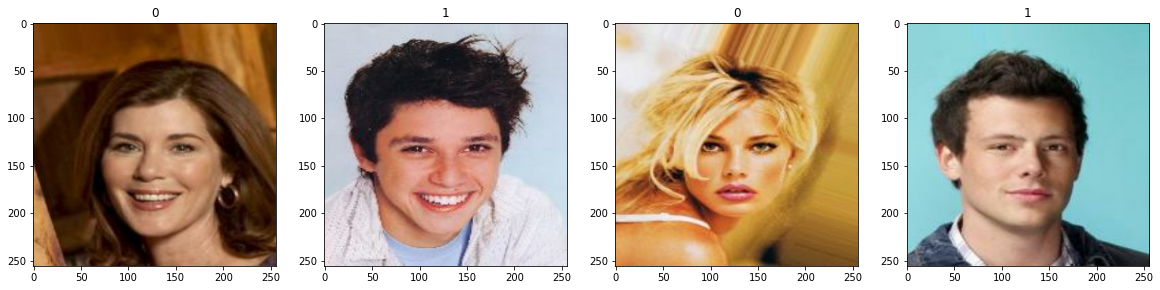

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Since the data is coverted into array, howver, they are 250x250 in size, which gives the arrays of number also similar in range. This is expensive and power consuming, hence, we scale the data down by deviding them by 225.

In [16]:
data = unscaled_df.map(lambda x,y: (x/255, y))

As we can see, after scaling them, the arrays are now within the range of 0 to 1. This will help the model train much faster

In [17]:
data.as_numpy_iterator().next()

(array([[[[0.7254902 , 0.74509805, 0.7607843 ],
          [0.72761947, 0.7472273 , 0.7629136 ],
          [0.7294118 , 0.7490196 , 0.7647059 ],
          ...,
          [0.7295956 , 0.73333335, 0.74024206],
          [0.73333335, 0.73333335, 0.7411765 ],
          [0.73333335, 0.73333335, 0.7411765 ]],
 
         [[0.72853863, 0.7481465 , 0.76383275],
          [0.7290127 , 0.74862057, 0.76430684],
          [0.7294118 , 0.7490196 , 0.7647059 ],
          ...,
          [0.7295956 , 0.73333335, 0.74024206],
          [0.73333335, 0.73333335, 0.7411765 ],
          [0.73333335, 0.73333335, 0.7411765 ]],
 
         [[0.7294118 , 0.7490196 , 0.7647059 ],
          [0.7294118 , 0.7490196 , 0.7647059 ],
          [0.7294118 , 0.7490196 , 0.7647059 ],
          ...,
          [0.7295956 , 0.73333335, 0.74024206],
          [0.73333335, 0.73333335, 0.7411765 ],
          [0.73333335, 0.73333335, 0.7411765 ]],
 
         ...,
 
         [[0.77254903, 0.8       , 0.8235294 ],
          [0.77254

## Build the Model

Let's divde 2000 images in the dataset into 3 sets with the following ratio:
- 70% : train set
- 20% : validation set
- 10% : test set

We can set multiple set size but these ratio are highly recommended and widely used

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Train the model

We use the Sequential model to train the data since it is highly recommended for image classification. There are better models, however, they cost a lot of computer's power. And since the images in our dataset is well defined, high resolution, with clear visual, we do not need higher performance models

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

From here, we getting more technical with adding multiple layers such as convolution, pooling, flatten, and dense. This is where graph theory takes place. We will go in more detail later.

In [22]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

Here is the summary of the model, which will be explained in detail

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

Let's fit the model

In [ ]:
hist = model.fit(train, epochs = 5, validation_data=val )

Epoch 1/5
44/44 [==============================] - 53s 1s/step - loss: 0.7009 - accuracy: 0.6491 - val_loss: 0.4819 - val_accuracy: 0.7969
Epoch 2/5
44/44 [==============================] - 53s 1s/step - loss: 0.4553 - accuracy: 0.8011 - val_loss: 0.3601 - val_accuracy: 0.8542
Epoch 3/5
44/44 [==============================] - 53s 1s/step - loss: 0.2705 - accuracy: 0.8984 - val_loss: 0.2820 - val_accuracy: 0.8906
Epoch 4/5
44/44 [==============================] - 53s 1s/step - loss: 0.1818 - accuracy: 0.9297 - val_loss: 0.2750 - val_accuracy: 0.8698
Epoch 5/5
44/44 [==============================] - 54s 1s/step - loss: 0.1298 - accuracy: 0.9538 - val_loss: 0.2437 - val_accuracy: 0.9115


Let's look at the comparision between loss and val_loss to see how well the model perform. As we can see the val_loss kind of goes off track with loss (decreases slower than loss in a small margin), this is a sligh indication of overfitting, which we will also discuss more on how to fix them later.

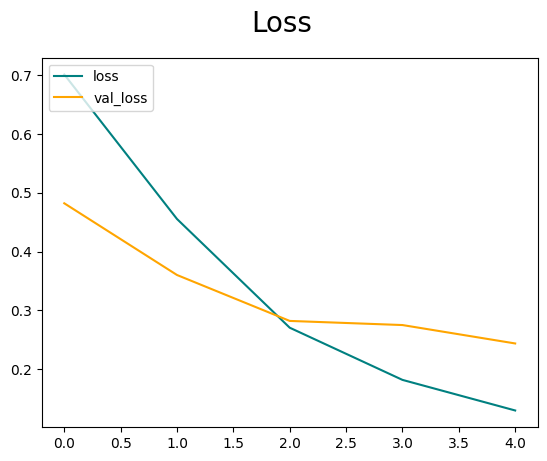

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

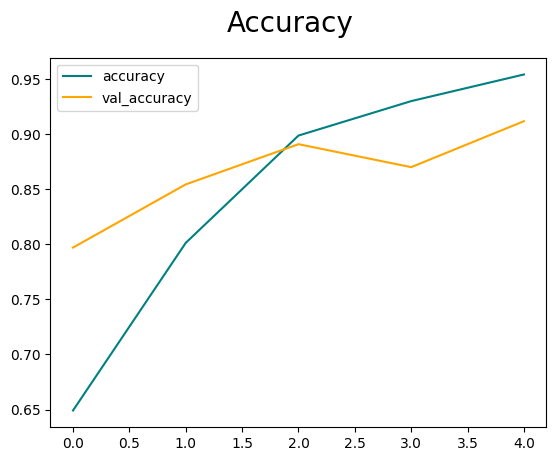

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

1/1 [==============================] - 0s 313ms/step
tf.Tensor(0.92391306, shape=(), dtype=float32) tf.Tensor(0.90425533, shape=(), dtype=float32) tf.Tensor(0.9166667, shape=(), dtype=float32)


## Test the model

Let's import some random photos and have a look at the model's predictions

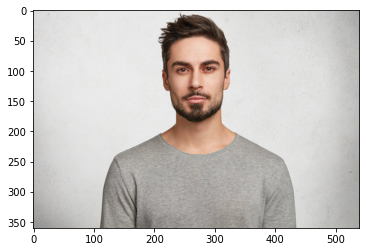

In [27]:
img = cv2.imread('male.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

First, we need to resize the photos to 256x256 so it has the same sizes with our training data.

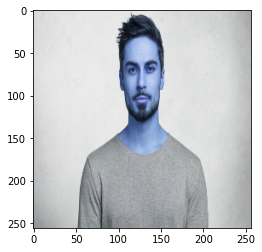

In [29]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

## The prediction gives the correct results

In [35]:
example1 = model.predict(np.expand_dims(resize/255, 0))
if example1 > 0.5: 
    print(f'Prediction is Male')
else:
    print(f'Prediction is Female')

1/1 [==============================] - 0s 28ms/step
Prediction is Male


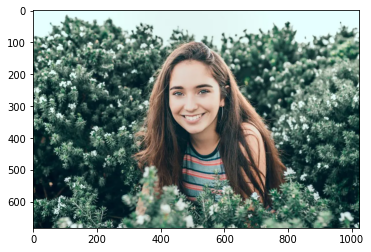

In [40]:
img = cv2.imread('female2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

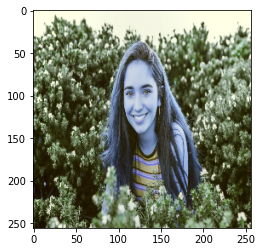

In [41]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [42]:
example2 = model.predict(np.expand_dims(resize/255, 0))
if example2 > 0.5: 
    print(f'Prediction is Male')
else:
    print(f'Prediction is Female')

1/1 [==============================] - 0s 21ms/step
Prediction is Female


## Save the model for further usage

In [44]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','GenderClassification.h5'))